# Méthode du synthetic control pour mesurer l'effet des "incentives" à la vaccination aux États-Unis

In [ ]:
from google.colab import drive
drive._mount('/content/drive/')

Mounted at /content/drive/


## 1. Définitions

In [ ]:
import numpy as np
import pandas as pd

states = [ 'AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA',
           'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
           'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM',
           'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
           'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']

states_names = {"AL":"Alabama", "AK":"Alaska", "AZ":"Arizona", "AR":"Arkansas",
                "CA":"California", "CO":"Colorado", "CT":"Connecticut",
                "DE":"Delaware", "FL":"Florida", "GA":"Georgia", "HI":"Hawaii",
                "ID":"Idaho", "IL":"Illinois", "IN":"Indiana", "IA":"Iowa",
                "KS":"Kansas", "KY":"Kentucky", "LA":"Louisiana", "ME":"Maine",
                "MD":"Maryland", "MA":"Massachusetts", "MI":"Michigan",
                "MN":"Minnesota", "MS":"Mississippi", "MO":"Missouri", "MT":"Montana",
                "NE":"Nebraska", "NV":"Nevada", "NH":"New Hampshire", "NJ":"New Jersey",
                "NM":"New Mexico", "NY":"New York", "NC":"North Carolina",
                "ND":"North Dakota", "OH":"Ohio", "OK":"Oklahoma", "OR":"Oregon",
                "PA":"Pennsylvania", "RI":"Rhode Island", "SC":"South Carolina",
                "SD":"South Dakota", "TN":"Tennessee", "TX":"Texas", "UT":"Utah",
                "VT":"Vermont", "VA":"Virginia", "WA":"Washington", "WV":"West Virginia",
                "WI":"Wisconsin", "WY":"Wyoming"}


In [ ]:
df_states = {}
for X in states:
  # fichiers csv à trouver dans le drive partagé
    path = '/content/drive/MyDrive/incentive_synthetic/state_vax_csv/'+X+'.csv'
    df_states[X] = pd.read_csv(path, sep=',' )
    df_states[X] = df_states[X].loc[::-1].reset_index(drop=True)
    df_states[X] = df_states[X].loc[67:,:].reset_index()


# On s'intéresse à la colonne du pourcentage de personnes ayant reçu au moins une dose. 
# C'est notre "response variable" que l'on cherche à modéliser après l'intervention.

In [ ]:
df_states['CA'].loc[:,["Date", "Distributed", "Administered_Dose1_Pop_Pct", 'Admin_Per_100K']]

,Date,Distributed,Administered_Dose1_Pop_Pct,Admin_Per_100K
0,02/19/2021,"9,164,130",13.0,"17,626"
1,02/20/2021,"9,178,020",13.4,"18,227"
2,02/21/2021,"9,178,020",13.7,"18,864"
3,02/22/2021,"9,178,020",13.9,"19,247"
4,02/23/2021,"10,168,620",14.1,"19,559"
...,...,...,...,...
307,12/23/2021,"75,862,805",82.0,"163,722"
308,12/24/2021,"75,917,465",82.2,"164,299"
309,12/25/2021,"75,915,965",82.4,"164,977"
310,12/26/2021,"75,684,685",82.4,"165,199"


In [ ]:
#On remarque qu'il y a des soucis dans le report des doses administrées : il arrive que le pourcentage de doses
#administrées diminue, alors qu'il ne devrait qu'augmenter ou rester constant (cf. explications dans le rapport)
#On décide donc de remédier à ces erreurs en fixant un seuil pour éviter que les données ne diminuent
#Dans un second temps, on effectue une interpolation sur la période où l'on constate des erreurs de report

tf = len(df_states['CA'])

for state in states:
    for t in range(1,tf):
        if df_states[state].loc[t, 'Administered_Dose1_Pop_Pct'] < df_states[state].loc[t-1, 'Administered_Dose1_Pop_Pct']:
            #on a un souci à partir du temps t
            j = t
            flag = True
            while j < tf and flag:
                if df_states[state].loc[j, 'Administered_Dose1_Pop_Pct'] >= df_states[state].loc[t-1, 'Administered_Dose1_Pop_Pct']:
                    #on a trouvé le plus petit indice pour lequel les données redeviennent cohérentes
                    a_t = df_states[state].loc[t-1, 'Administered_Dose1_Pop_Pct']
                    a_j = df_states[state].loc[j, 'Administered_Dose1_Pop_Pct']
                    
                    #on interpole linéairement
                    for i in range(t,j):
                        df_states[state].loc[i, 'Administered_Dose1_Pop_Pct'] = ((a_t-a_j)/(t-1-j))*(i-j) + a_j
                    flag = False
                j +=1 
                    
            if flag:
                #on a pas trouvé de plus petit indice: on crée un plateau à partir du temps t
                for i in range(t,tf):
                    df_states[state].loc[i, 'Administered_Dose1_Pop_Pct'] = df_states[state].loc[t-1, 'Administered_Dose1_Pop_Pct']

In [ ]:
df_dose1 = {}
for X in states:
    df_dose1[X] = df_states[X].loc[:,'Administered_Dose1_Pop_Pct']

ls_dose1 = {}
for X in states:
    ls_dose1[X] = df_dose1[X].to_numpy()

In [ ]:
df_prm = pd.read_excel('/content/drive/MyDrive/incentive_synthetic/parameters.xlsx', 'Sheet4', index_col=0)
df_prm = df_prm.drop(columns=['Population','Total Firearm Death','Number of people under poverty level'])
prm = df_prm.to_numpy()
    
state_vector = {}
for i in range(len(states)):
    state_vector[states[i]] = prm[i]

In [ ]:
df_prm

,Under 18 years old,Over 65 years old,Median age,White,Black,American Indian,Asian,Hawaiian,% higher education achievement,% high school achievement,% literacy,% urban population,Population density (number of people/square mile),% unemployement,Crime Rate,Firearms Death Rate,Poverty rate,GINI index,Median income (in US dollars),2016 Trump vote,2020 Trump vote,Governor: democrat (1) / republican (0),Gun ownership rate,Adult obesity rate,Hypertension,Number of Covid-19 cases per 100k,Number of Covid-19 deaths per 100k,% non couverts par une assurance maladie,Covid vax hesitancy (somewhat hesitant),Covid vax hesitancy (all),Access to Care (score between 0 and 1)
État,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AK,0.246,0.118,34,0.6458,0.0328,0.1489,0.0623,0.0125,0.30,0.93,0.908,0.660,1,0.063,8.4,23.0,0.1062,47.69,77640,0.5128,0.528,0,0.645,0.319,0.328,18992.406482,110.041077,0.115,0.059913,0.184476,0.577950
AL,0.222,0.169,39,0.6809,0.2664,0.0052,0.0136,0.0005,0.26,0.86,0.852,0.590,97,0.031,8.3,21.4,0.1613,41.74,50536,0.6208,0.620,0,0.555,0.390,0.425,17151.932876,326.828378,0.097,0.115802,0.266797,0.136664
AR,0.232,0.170,38,0.7672,0.1532,0.0068,0.0152,0.0029,0.23,0.87,0.863,0.562,58,0.040,8.6,17.7,0.1636,47.00,47597,0.6057,0.624,0,0.572,0.364,0.410,17209.633230,284.809749,0.091,0.092590,0.257836,0.267585
AZ,0.225,0.175,38,0.7722,0.0450,0.0450,0.0331,0.0021,0.30,0.87,0.869,0.898,66,0.057,5.9,15.2,0.1388,46.82,58945,0.4867,0.491,0,0.463,0.309,0.325,16814.680389,298.843876,0.111,0.076307,0.208703,0.286535
CA,0.225,0.143,37,0.5970,0.0579,0.0077,0.1449,0.0040,0.34,0.83,0.769,0.950,254,0.075,4.6,7.9,0.1300,49.00,75235,0.3162,0.343,1,0.283,0.303,0.278,12016.615719,183.421722,0.078,0.054995,0.135921,0.574505
CO,0.219,0.142,37,0.8400,0.0416,0.0098,0.0318,0.0015,0.41,0.92,0.901,0.862,57,0.056,3.9,14.3,0.0960,45.90,72331,0.4325,0.419,1,0.451,0.242,0.258,13829.250030,152.516108,0.078,0.057679,0.192175,0.602354
CT,0.204,0.172,41,0.7592,0.1072,0.0028,0.0451,0.0003,0.39,0.91,0.914,0.880,734,0.068,2.8,4.6,0.0969,49.00,78444,0.4093,0.392,1,0.236,0.292,0.309,11536.546707,247.778089,0.059,0.037685,0.098028,0.771748
DE,0.209,0.187,41,0.6876,0.2218,0.0039,0.0387,0.0006,0.32,0.90,0.893,0.833,508,0.053,5.6,10.9,0.1105,45.00,68287,0.4172,0.398,1,0.344,0.365,0.272,15267.970473,220.073858,0.066,0.060046,0.138619,0.584841
FL,0.197,0.205,42,0.7512,0.1607,0.0028,0.0273,0.0006,0.30,0.88,0.803,0.912,409,0.049,5.0,12.6,0.1308,49.00,55660,0.4902,0.512,0,0.353,0.284,0.335,17094.356822,283.293347,0.131,0.079888,0.202361,0.194660


In [ ]:
df_prm_scaled = (df_prm-df_prm.mean())/df_prm.std()
prm_scaled = df_prm_scaled.to_numpy()

state_vector_scaled = {}
for i in range(len(states)):
    state_vector_scaled[states[i]] = prm_scaled[i]

In [ ]:
df_prm_scaled

,Under 18 years old,Over 65 years old,Median age,White,Black,American Indian,Asian,Hawaiian,% higher education achievement,% high school achievement,% literacy,% urban population,Population density (number of people/square mile),% unemployement,Crime Rate,Firearms Death Rate,Poverty rate,GINI index,Median income (in US dollars),2016 Trump vote,2020 Trump vote,Governor: democrat (1) / republican (0),Gun ownership rate,Adult obesity rate,Hypertension,Number of Covid-19 cases per 100k,Number of Covid-19 deaths per 100k,% non couverts par une assurance maladie,Covid vax hesitancy (somewhat hesitant),Covid vax hesitancy (all),Access to Care (score between 0 and 1)
État,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AK,1.230784,-2.490948,-1.940392,-0.930504,-0.769213,4.502030,0.359097,0.632946,-0.245495,1.247459,0.582675,-0.521106,-0.760356,1.084973,1.290618,2.034909,-0.678122,0.762078,1.458899,0.199490,0.261945,-0.951113,1.547017,-0.078748,-0.081266,1.349134,-1.591401,0.989070,-0.665942,-0.438409,0.358003
AL,-0.009301,0.217759,0.159599,-0.655402,1.685610,-0.386748,-0.518640,-0.211357,-1.012667,-1.320839,-0.733043,-1.001705,-0.400175,-1.154971,1.252546,1.708932,1.316354,-2.338554,-1.175728,1.256236,1.152518,-0.951113,0.864443,1.701870,2.158153,0.777943,1.542338,0.401891,1.610761,0.862794,-1.630616
AR,0.507401,0.270871,-0.260399,0.020989,0.496030,-0.332314,-0.489802,-0.042497,-1.588047,-0.953939,-0.474598,-1.193944,-0.546499,-0.524987,1.366760,0.955111,1.399608,0.402509,-1.461411,1.108487,1.191238,-0.951113,0.993373,1.049813,1.811851,0.795851,0.934943,0.206165,0.665180,0.721153,-1.040629
AZ,0.145710,0.536430,-0.260399,0.060178,-0.641007,0.967277,-0.167184,-0.098783,-0.245495,-0.953939,-0.333628,1.112929,-0.516484,0.664983,0.338835,0.445773,0.501913,0.308708,-0.358336,-0.055890,-0.096221,-0.951113,0.166700,-0.329540,-0.150526,0.673277,1.137812,0.858586,0.001882,-0.055467,-0.955236
CA,0.145710,-1.163151,-0.680397,-1.312982,-0.505445,-0.301696,1.847825,0.034898,0.521677,-2.421538,-2.683124,1.469945,0.188870,1.924952,-0.156092,-1.041495,0.183376,1.444738,1.225123,-1.724178,-1.528882,1.030372,-1.198449,-0.480015,-1.235605,-0.815801,-0.530657,-0.217909,-0.866282,-1.205904,0.342477
CO,-0.164311,-1.216263,-0.680397,0.591572,-0.676737,-0.230252,-0.190615,-0.140999,1.864229,0.880559,0.418210,0.865764,-0.550250,0.594985,-0.422592,0.262411,-1.047335,-0.170717,0.942842,-0.586220,-0.793191,1.030372,0.075690,-2.009842,-1.697341,-0.253250,-0.977409,-0.217909,-0.756920,-0.316725,0.467979
CT,-0.939364,0.377095,0.999596,-0.041712,0.012631,-0.468397,0.049096,-0.225429,1.480642,0.513660,0.723645,0.989346,1.989771,1.434964,-0.841376,-1.713822,-1.014757,1.444738,1.537052,-0.813224,-1.054555,1.030372,-1.554905,-0.755885,-0.519915,-0.964790,0.399637,-0.837709,-1.571430,-1.804855,1.231340
DE,-0.681013,1.173773,0.999596,-0.602889,1.216924,-0.430974,-0.066254,-0.204321,0.138091,0.146760,0.230251,0.666659,1.141847,0.384990,0.224621,-0.430289,-0.522473,-0.639720,0.549747,-0.735925,-0.996474,1.030372,-0.735815,1.074892,-1.374126,0.193256,-0.000837,-0.609361,-0.660514,-1.163254,0.389055
FL,-1.301055,2.129787,1.419594,-0.104413,0.574845,-0.468397,-0.271720,-0.204321,-0.245495,-0.587040,-1.884296,1.209049,0.770411,0.104997,-0.003807,-0.083939,0.212334,1.444738,-0.677652,-0.021644,0.107062,-0.951113,-0.667558,-0.956518,0.080342,0.760075,0.913023,1.511007,0.147763,-0.155711,-1.369262


In [ ]:
df_prm_scaled.corr()

,Under 18 years old,Over 65 years old,Median age,White,Black,American Indian,Asian,Hawaiian,% higher education achievement,% high school achievement,% literacy,% urban population,Population density (number of people/square mile),% unemployement,Crime Rate,Firearms Death Rate,Poverty rate,GINI index,Median income (in US dollars),2016 Trump vote,2020 Trump vote,Governor: democrat (1) / republican (0),Gun ownership rate,Adult obesity rate,Hypertension,Number of Covid-19 cases per 100k,Number of Covid-19 deaths per 100k,% non couverts par une assurance maladie,Covid vax hesitancy (somewhat hesitant),Covid vax hesitancy (all),Access to Care (score between 0 and 1)
Under 18 years old,1.000000,-0.770594,-0.913930,-0.063072,0.016944,0.311793,-0.100505,-0.006747,-0.309742,-0.134407,-0.034383,0.093654,-0.396851,-0.239412,0.198526,0.383376,0.110803,-0.143092,-0.131387,0.414463,0.520524,-0.328714,0.390922,0.310784,-0.054719,0.516458,0.096213,0.510472,0.464383,0.518385,-0.498972
Over 65 years old,-0.770594,1.000000,0.879120,0.215848,-0.097743,-0.226212,-0.043442,0.054003,-0.105108,0.148736,0.104260,-0.325547,0.103442,-0.025910,-0.173462,-0.150241,0.111728,-0.100719,-0.278667,-0.033298,-0.098559,0.144759,-0.091133,-0.032737,0.210268,-0.248760,0.044554,-0.344625,-0.119598,-0.122697,0.257864
Median age,-0.913930,0.879120,1.000000,0.179586,0.017228,-0.364334,-0.037116,-0.066593,0.117245,0.120762,0.085548,-0.270874,0.306202,0.096297,-0.158953,-0.278136,-0.010752,0.008328,-0.059406,-0.205970,-0.315887,0.256799,-0.251097,-0.098096,0.211121,-0.442856,-0.030594,-0.405454,-0.291290,-0.342593,0.343940
White,-0.063072,0.215848,0.179586,1.000000,-0.536897,0.015582,-0.717981,-0.593799,-0.048032,0.412510,0.630678,-0.444082,-0.247947,-0.528625,-0.428930,0.041833,-0.136490,-0.317705,-0.264011,0.351152,0.349000,-0.170398,0.403850,0.056303,-0.118330,0.256814,-0.125429,-0.113271,0.091335,0.274637,0.171361
Black,0.016944,-0.097743,0.017228,-0.536897,1.000000,-0.330084,-0.103482,-0.178020,-0.170789,-0.543158,-0.445058,0.039429,0.226737,0.149523,0.662350,0.254795,0.441031,0.356900,-0.213725,0.080447,0.001303,-0.055521,-0.072271,0.473674,0.520176,0.059882,0.509069,0.249545,0.375144,0.110742,-0.458075
American Indian,0.311793,-0.226212,-0.364334,0.015582,-0.330084,1.000000,-0.101887,0.008889,-0.173118,0.170486,0.123354,-0.173081,-0.308050,-0.004121,0.070400,0.413063,0.076320,0.021849,-0.039827,0.201189,0.227897,-0.217687,0.404968,-0.028001,-0.110832,0.360088,-0.028090,0.294504,0.049317,0.152943,-0.034621
Asian,-0.100505,-0.043442,-0.037116,-0.717981,-0.103482,-0.101887,1.000000,0.888004,0.295534,0.011352,-0.335204,0.475519,0.215444,0.449182,-0.127747,-0.446144,-0.298499,0.014763,0.546532,-0.544831,-0.496806,0.313236,-0.556742,-0.451372,-0.259935,-0.514989,-0.325519,-0.256774,-0.462136,-0.479861,0.275087
Hawaiian,-0.006747,0.054003,-0.066593,-0.593799,-0.178020,0.008889,0.888004,1.000000,0.044626,0.142180,-0.142645,0.212454,-0.031606,0.204799,-0.110946,-0.212084,-0.197494,-0.200095,0.301202,-0.287870,-0.218610,0.137150,-0.281393,-0.312629,-0.118611,-0.359344,-0.372461,-0.172762,-0.267019,-0.257422,0.181839
% higher education achievement,-0.309742,-0.105108,0.117245,-0.048032,-0.170789,-0.173118,0.295534,0.044626,1.000000,0.437436,0.165827,0.450193,0.522987,0.142197,-0.476764,-0.714330,-0.751831,0.057181,0.841373,-0.745605,-0.764085,0.203823,-0.627322,-0.739362,-0.675775,-0.564218,-0.420380,-0.466239,-0.776781,-0.747154,0.600431
% high school achievement,-0.134407,0.148736,0.120762,0.412510,-0.543158,0.170486,0.011352,0.142180,0.437436,1.000000,0.796937,-0.179159,-0.048286,-0.360601,-0.577264,-0.287957,-0.752512,-0.538933,0.418025,-0.122562,-0.100040,-0.080119,0.044488,-0.439833,-0.512830,-0.151241,-0.583494,-0.433900,-0.432890,-0.162472,0.593964


['California', 'Colorado', 'Connecticut', 'Delaware', 'Hawaii', 'Illinois', 'Massachusetts', 'Maryland', 'Maine', 'Minnesota', 'New Hampshire', 'New Jersey', 'New York', 'Oregon', 'Pennsylvania', 'Rhode Island', 'Virginia', 'Vermont', 'Washington'] 19
['Alabama', 'Arkansas', 'Arizona', 'Florida', 'Georgia', 'Indiana', 'Kentucky', 'Louisiana', 'Michigan', 'Missouri', 'Mississippi', 'North Carolina', 'New Mexico', 'Nevada', 'Ohio', 'Oklahoma', 'South Carolina', 'Tennessee', 'Texas', 'West Virginia'] 20
['Alaska', 'Iowa', 'Idaho', 'Kansas', 'Montana', 'North Dakota', 'Nebraska', 'South Dakota', 'Utah', 'Wisconsin', 'Wyoming'] 11
[] 0


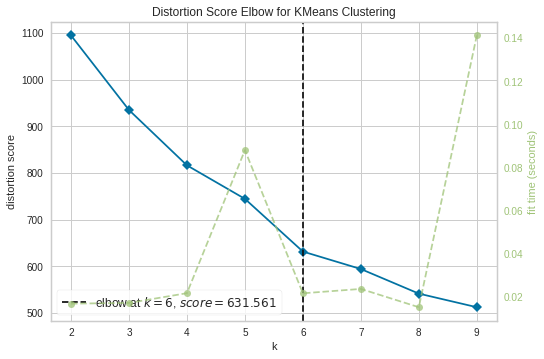

In [ ]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# Nombre de groupes
n = 3

km = KMeans(
    n_clusters= n, init='random',
    n_init=10, max_iter=300, 
    tol=1e-05, random_state=0
)

y_km = km.fit_predict(df_prm_scaled)

states_A, states_B, states_C, states_D = [], [], [], []
states_A_names, states_B_names, states_C_names, states_D_names = [], [], [], []
for i in range(len(states)):
    if y_km[i] == 0:
        states_A_names.append(states_names[states[i]])
        states_A.append(states[i])
    elif y_km[i] == 1:
        states_B_names.append(states_names[states[i]])
        states_B.append(states[i])
    elif y_km[i] == 2 and n >= 3:
        states_C_names.append(states_names[states[i]])
        states_C.append(states[i])
    elif y_km[i] == 3 and n>= 4:
        states_D_names.append(states_names[states[i]])
        states_D.append(states[i])

group_states = {}

for X in states:
  if X in states_A:
    group_states[X] = 'A'
  if X in states_B:
    group_states[X] = 'B'
  if X in states_C:
    group_states[X] = 'C'
  if X in states_D:
    group_states[X] = 'D'

print(states_A_names, len(states_A_names))
print(states_B_names, len(states_B_names))
print(states_C_names, len(states_C_names))
print(states_D_names, len(states_D_names))

# Elbow method K-means
visualizer = KElbowVisualizer(km, k=(2,10))

visualizer.fit(df_prm_scaled)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [ ]:
target_states_all = ['AL', 'AR', 'CA', 'CO', 'CT', 'DE', 'IL', 'ID', 'KY', 'ME', 'MD',
                'MI', 'MN', 'NJ', 'NY', 'OH', 'OR', 'WV']
control_states_all = []
for X in states:
  if X not in target_states_all:
    control_states_all.append(X)


target_states = {'A': [], 'B': [], 'C':[], 'D':[]}
control_states = {'A': [], 'B': [], 'C':[], 'D':[]}

for X in states:
    if X in states_A and X in target_states_all:
        target_states['A'].append(X)
    elif X in states_A and X not in target_states_all:
        control_states['A'].append(X)
    elif X in states_B and X in target_states_all:
        target_states['B'].append(X)
    elif X in states_B and X not in target_states_all:
        control_states['B'].append(X)
    elif X in states_C and X in target_states_all:
        target_states['C'].append(X)
    elif X in states_C and X not in target_states_all:
        control_states['C'].append(X)
    elif X in states_D and X in target_states_all:
        target_states['D'].append(X)
    elif X in states_D and X not in target_states_all:
        control_states['D'].append(X)



print("Number of potential target states in group A = " + str(len(target_states['A'])) + "/" + str(len(states)))
print("Number of control states in group A = " + str(len(control_states['A'])) + "/" + str(len(states)))
print("Number of potential target states in group B = " + str(len(target_states['B'])) + "/" + str(len(states)))
print("Number of control states in group B = " + str(len(control_states['B'])) + "/" + str(len(states)))
print("Number of potential target states in group C = " + str(len(target_states['C'])) + "/" + str(len(states)))
print("Number of control states in group C = " + str(len(control_states['C'])) + "/" + str(len(states)))
print("Number of potential target states in group D = " + str(len(target_states['D'])) + "/" + str(len(states)))
print("Number of control states in group D = " + str(len(control_states['D'])) + "/" + str(len(states)))

Number of potential target states in group A = 11/50
Number of control states in group A = 8/50
Number of potential target states in group B = 6/50
Number of control states in group B = 14/50
Number of potential target states in group C = 1/50
Number of control states in group C = 10/50
Number of potential target states in group D = 0/50
Number of control states in group D = 0/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars


Pourcentage des états ayant voté Trump en 2016 dans le groupe A: 0.0%
Pourcentage des états ayant voté Trump en 2016 dans le groupe B: 70.0%
Pourcentage des états ayant voté Trump en 2016 dans le groupe C: 81.82%
Pourcentage des états ayant voté Trump en 2016 dans le groupe D: nan%


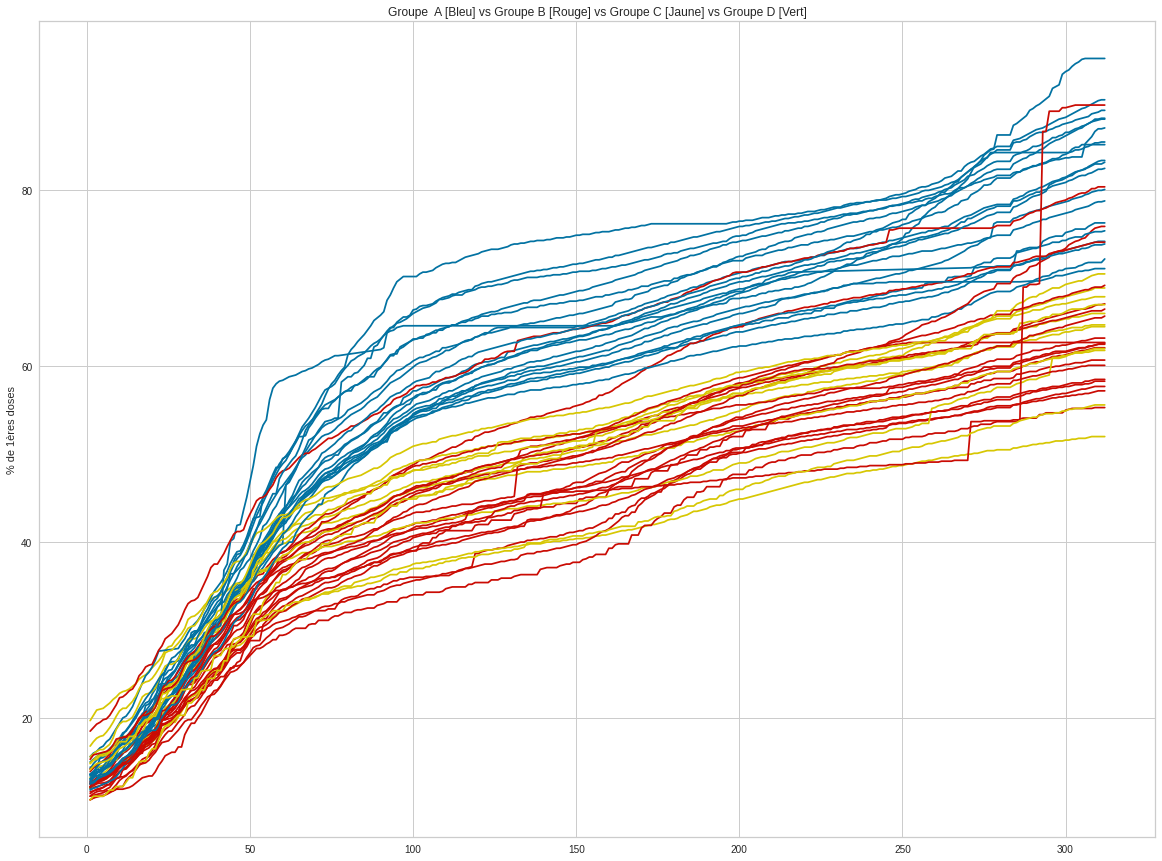

In [ ]:
# Interprétation des groupes
# Remarque: même en supprimant les paramètres "politiques" (vote Trump 2020, 2016, ...)
#           le clustering génère les mêmes groupes. 

import matplotlib.pyplot as plt

vote_A, vote_B, vote_C, vote_D = [], [], [], []
states_A = np.concatenate((target_states['A'], control_states['A']))
states_B = np.concatenate((target_states['B'], control_states['B']))
states_C = np.concatenate((target_states['C'], control_states['C']))
states_D = np.concatenate((target_states['D'], control_states['D']))

for X in states_A:
    if df_prm.loc[X, "2016 Trump vote"] >= 0.5:
        vote_A.append(1)
    else:
        vote_A.append(0)       
pct_A = 100*np.sum(vote_A)/len(vote_A)

for X in states_B:
    if df_prm.loc[X, "2016 Trump vote"] >= 0.5:
        vote_B.append(1)
    else:
        vote_B.append(0)
pct_B = 100*np.sum(vote_B)/len(vote_B)

for X in states_C:
    if df_prm.loc[X, "2016 Trump vote"] >= 0.5:
        vote_C.append(1)
    else:
        vote_C.append(0)
pct_C = 100*np.sum(vote_C)/len(vote_C)

for X in states_D:
    if df_prm.loc[X, "2016 Trump vote"] >= 0.5:
        vote_D.append(1)
    else:
        vote_D.append(0)
pct_D = 100*np.sum(vote_D)/len(vote_D)
        
print("Pourcentage des états ayant voté Trump en 2016 dans le groupe A: "+str(pct_A)+"%")
print("Pourcentage des états ayant voté Trump en 2016 dans le groupe B: "+str(np.round(pct_B,2))+"%")
print("Pourcentage des états ayant voté Trump en 2016 dans le groupe C: "+str(np.round(pct_C,2))+"%")
print("Pourcentage des états ayant voté Trump en 2016 dans le groupe D: "+str(np.round(pct_D,2))+"%")

plt.figure(figsize=(20,15))
for X in states:
    c = 0
    if X in states_A:
        c = 'b'
    elif X in states_B:
        c = 'r'
    elif X in states_C:
        c = 'y'
    elif X in states_D:
        c = 'g'

    t = np.linspace(1,len(ls_dose1[X]), len(ls_dose1[X]))
    plt.plot(t, ls_dose1[X], color=c)
    
plt.ylabel('% de 1ères doses')
plt.title('Groupe  A [Bleu] vs Groupe B [Rouge] vs Groupe C [Jaune] vs Groupe D [Vert]')
plt.show()


# Carte 
import plotly.express as px

c_list = []
for X in states:
    if X in states_A:
        c_list.append(1)
    elif X in states_B:
        c_list.append(2)
    elif X in states_C:
        c_list.append(3)
    elif X in states_D:
        c_list.append(4)    
    
fig = px.choropleth(locations=states, locationmode="USA-states", color=c_list, scope="usa")
fig.show()

In [ ]:
incentives = pd.read_excel('/content/drive/MyDrive/incentive_synthetic/incentive_list.xlsx', 'Sheet2', index_col=None)

dates = {}
category = {}
for X in target_states_all:
    dates[X] = incentives.loc[incentives["State Code"] == X, "Incentive t0"]
    dates[X] = str(dates[X].item())[:10]
    category[X] = incentives.loc[incentives["State Code"] == X, "Category"]
    category[X] = int(category[X])

print(dates)
print(category)

KeyError: ignored

# 


## 2. Analyse en composantes principales
### Indépendant du synthetic control (voir notebook de MLC)

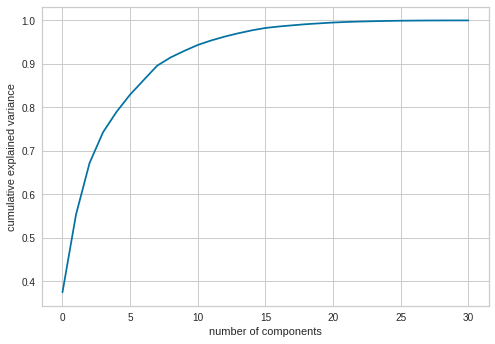

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA().fit(df_prm_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

Text(0, 0.5, 'Percent Variance Explained')

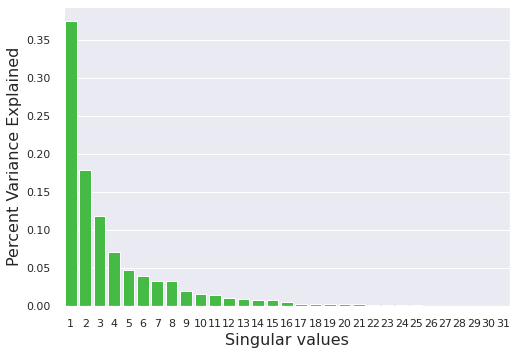

In [ ]:
u, s, v = np.linalg.svd(df_prm_scaled, full_matrices=True)

v10 = v[:5,:]

var_explained = np.round(s**2/np.sum(s**2), decimals=3)
var_explained

import seaborn as sns; sns.set()
sns.barplot(x=list(range(1,len(var_explained)+1)),
            y=var_explained, color="limegreen")
plt.xlabel('Singular values', fontsize=16)
plt.ylabel('Percent Variance Explained', fontsize=16)

In [ ]:
prm_scaled_t = np.transpose(prm_scaled)
prm_pca = np.transpose(np.dot(v10, prm_scaled_t))

state_vector_pca = {}
for i in range(len(states)):
    state_vector_pca[states[i]] = prm_pca[i]

### PCR (non achevé)

In [ ]:
# X_same = df_prm_scaled.loc[target_states,:]
# X = df_prm_scaled.loc[control_states,:]

In [ ]:
# X_same_t = np.transpose(X_same)
# X_t = np.transpose(X)
# y = np.transpose(df_prm_scaled.loc['AL',:])

# X_t.head()

In [ ]:
# from sklearn.model_selection import train_test_split
# from sklearn.pipeline import make_pipeline
# from sklearn.linear_model import LinearRegression
# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA
# from sklearn.cross_decomposition import PLSRegression

In [ ]:
# pcr = make_pipeline(StandardScaler(), PCA(n_components=0.9), LinearRegression())
# pcr_same = make_pipeline(StandardScaler(), PCA(n_components=0.9), LinearRegression())

# pcr.fit(X_t, y)
# pcr_same.fit(X_same_t,y)

# pca = pcr.named_steps["pca"]  # retrieve the PCA step of the pipeline
# pca_same = pcr_same.named_steps["pca"]

# X_t_transformed = pca.transform(X_t)
# X_same_t_transformed = pca_same.transform(X_same_t)

# print(np.shape(X_t_transformed))
# print(np.shape(X_t))

# # df_X_t_transformed = pd.DataFrame(X_t_transformed, index = control_states, columns=["PC"+ str(i) for i in range(1,11)])
# # print(df_X_t_transformed)



# 

## 3. Retour au synthetic control

In [ ]:
def norm(w, v, x, x1):
    pred = np.dot(np.transpose(x), w)
    pred_diff = x1 - pred
    pred_diff_v = np.multiply(pred_diff, v)
    res = np.dot(pred_diff, pred_diff_v)
    return np.sqrt(res)

def mspe(y1, y, w):
    interv = np.dot(np.transpose(y), w)
    interv_diff = y1 - interv
    res = np.dot(interv_diff, interv_diff)
    return res

In [ ]:
from scipy.optimize import minimize, fmin_slsqp

def constraint(w, v, x, x1):
    return np.sum(w) - 1

def con(v):
    return np.sum(v) - 1
cons = {'type':'eq', 'fun': con}

def mspe_opt_w(v_guess, w_guess, x, x1, y, y1):
    w_opt = fmin_slsqp(norm, w_guess, f_eqcons=constraint, bounds=[(0.0, 1.0)]*len(w_guess),
             args=(v_guess, x, x1), disp=False)
    return mspe(y1, y, w_opt)

def opt_v(v_guess, w_guess, x, x1, y, y1):
    v_opt = minimize(mspe_opt_w, v_guess, constraints = cons, bounds=[(0.0, 1.0)]*len(v_guess), 
             args=(w_guess, x, x1, y, y1))
    return v_opt.x

def opt_w(w_guess, v, x, x1):
    w_opt = fmin_slsqp(norm, w_guess, f_eqcons=constraint, bounds=[(0.0, 1.0)]*len(w_guess),
             args=(v, x, x1), disp=False)
    return w_opt

In [ ]:
import datetime

inc_t0 = {}

for X in target_states_all:
  # 19/02/2021 approx première date à laquelle les % de vax sont non nuls
  start = datetime.date(2021,2,19)
  t0_date_str = dates[X]
  t0_date = datetime.date(int(t0_date_str[:4]), int(t0_date_str[5:7]), int(t0_date_str[9:]))
  t0 = t0_date - start
  t0 = t0.days
  inc_t0[X] = t0


In [ ]:
y1_prediction = {}

dfs={}
dfs['A'] = pd.DataFrame(columns=control_states['A'])
dfs['B'] = pd.DataFrame(columns=control_states['B'])
dfs['C'] = pd.DataFrame(columns=control_states['C'])
dfs['D'] = pd.DataFrame(columns=control_states['D'])

def synthetic(ls_dose, state_vector, t_fit, plot=True):
  V = []
  if plot==True:
    print("Les poids des différents états de contrôle dans le synthetic control: ")
    print("")

  for Y in target_states_all:
      
      X_target = Y
      if plot == True:
        print('The state of', states_names[X_target],group_states[X_target], 'is simulated with:')
      
      t0 = inc_t0[X_target]
      
      if X_target in states_A:
          L = 'A'
      elif X_target in states_B:
          L = 'B'
      elif X_target in states_C:
          L = 'C'
      elif X_target in states_D:
          L = 'D'
      
      y1 = ls_dose1[X_target][t0-t_fit:t0]
      y = []
      for X in control_states_all:    
          y.append(ls_dose1[X][t0-t_fit:t0])

      y_post = []
      for X in control_states_all:    
          y_post.append(ls_dose1[X])

  #   Choisir ici state_vector_scaled (35 paramètres normalisés) 
  #   ou state_vector_pca (5 principaux paramètres du PCA).
  #       Il semble que les 35 paramètres normalisés génèrent un synthetic 
  #       plus proche du réel sur la période avant l'intervention.
      x1 = state_vector_scaled[X_target]

      x = []
      for X in control_states_all :    
              x.append(state_vector_scaled[X])
      
      k = len(x)
      j = len(x1)

      w_guess = np.array([1/k]*k)
      v_guess = np.array([1/j]*j)


      
      v_star = opt_v(v_guess, w_guess, x, x1, y, y1)
      w_star = opt_w(w_guess, v_star, x, x1)
      V.append(np.concatenate(([L], np.round(v_star, 3))))
      
      

      y1_prediction[X_target] = np.dot(np.transpose(y_post), w_star)
      
      df_new_row = pd.DataFrame(data=np.array([w_star]), columns=control_states_all)

      dfs[L]= pd.concat([dfs[L],df_new_row], ignore_index=True)
      
      inf = 0.01
      states_star = {}
      
      for k in range(len(w_star)):
          if w_star[k]>inf:
              states_star[control_states_all[k]] = w_star[k]
      
      sortedDict = sorted(states_star.items(), key=lambda x: x[1], reverse=True)

      if plot == True:
        for k in range(len(sortedDict)):
          print('   ', states_names[sortedDict[k][0]],group_states[sortedDict[k][0]],np.round(sortedDict[k][1],3)*100,'%' )

        t = np.linspace(1,len(ls_dose1[X_target]), len(ls_dose1[X_target]))
        t_zoom = np.linspace(t0-40,t0+70, 110)
        
        plt.figure(figsize=(20, 16))
        plt.subplot(2, 2, 1) # row 1, col 2 index 1
        plt.plot(t, ls_dose1[X_target], label='real')
        plt.plot(t, y1_prediction[X_target], label='synthetic')
        lbl = "t0=" + t0_date_str
        plt.axvline(x=t0, ls='--', label= lbl)
        plt.legend()
        plt.title(states_names[X_target]+ ' (Groupe '+L+' | Category '+str(category[X_target])+')')


        plt.subplot(2, 2, 2) # row 1, col 2 index 1
        plt.plot(t_zoom, ls_dose1[X_target][t0-40:t0+70], label='real')
        plt.plot(t_zoom, y1_prediction[X_target][t0-40:t0+70], label='synthetic')
        lbl = "t0=" + t0_date_str
        plt.axvline(x=t0, ls='--', label= lbl)
        plt.legend()
        plt.title(states_names[X_target] + ' [zoom] (Groupe '+L+' | Category '+str(category[X_target])+')')
        

        plt.subplot(2, 2, 3) # row 1, col 2 index 1
        for X in control_states_all:
            if X != X_target:
                plt.plot(t, ls_dose1[X], 'b--', linewidth=0.5)
        plt.plot(t, ls_dose1[X_target], label='real')
        plt.plot(t, y1_prediction[X_target], label='synthetic')
        lbl = "t0=" + t0_date_str
        plt.axvline(x=t0, ls='--', label= lbl)
        plt.legend()
        plt.title(states_names[X_target]+' vs autres états')

        plt.subplot(2, 2, 4) # row 1, col 2 index 1
        for i in range(len(control_states_all)):
            X = control_states_all[i]
            if X != X_target:
              if X in control_states[L]:
                th = 2*w_star[i]
                plt.plot(t, ls_dose1[X], 'g', linewidth=th)
              else:
                th = 2*w_star[i]
                plt.plot(t, ls_dose1[X], 'r', linewidth=th)
        plt.plot(t, ls_dose1[X_target], label='real')
        plt.plot(t, y1_prediction[X_target], label='synthetic')
        lbl = "t0=" + t0_date_str
        plt.axvline(x=t0, ls='--', label= lbl)
        plt.legend()
        plt.title(states_names[X_target]+' vs états contrôles finaux')

        plt.show()
        print('')
  return V

NameError: ignored

In [ ]:
synthetic(ls_dose1, state_vector_scaled, 40)

NameError: ignored

In [ ]:
# placebo state : synthetic control for control states 
# ici pour l'oregon 

y1_prediction_1 = {}
# dfs_placebo = {}

# dfs_placebo['A'] = pd.DataFrame(columns=control_states['A'])
# dfs_placebo['B'] = pd.DataFrame(columns=control_states['B'])
# dfs_placebo['C'] = pd.DataFrame(columns=control_states['C'])
# dfs_placebo['D'] = pd.DataFrame(columns=control_states['D'])

def synthetic_placebo(ls_dose, state_vector, t_fit, state, plot=True):
  V = []
  if plot==True:
    print("Les poids des différents états de contrôle dans le synthetic control: ")
    print("")

  for Y in control_states_all:
      
      X_target = Y
      if plot == True:
        print('The state of', states_names[X_target],group_states[X_target], 'is simulated with:')
      
      t0 = inc_t0[state]
      
      if X_target in states_A:
          L = 'A'
      elif X_target in states_B:
          L = 'B'
      elif X_target in states_C:
          L = 'C'
      elif X_target in states_D:
          L = 'D'
      
      control_states_all_modified = control_states_all.copy()
      control_states_all_modified.remove(X_target)

      y1 = ls_dose1[X_target][t0-t_fit:t0]
      y = []
      for X in control_states_all_modified:    
          y.append(ls_dose1[X][t0-t_fit:t0])

      y_post = []
      for X in control_states_all_modified:    
          y_post.append(ls_dose1[X])

  #   Choisir ici state_vector_scaled (35 paramètres normalisés) 
  #   ou state_vector_pca (5 principaux paramètres du PCA).
  #       Il semble que les 35 paramètres normalisés génèrent un synthetic 
  #       plus proche du réel sur la période avant l'intervention.
      x1 = state_vector_scaled[X_target]

      x = []
      for X in control_states_all_modified :    
              x.append(state_vector_scaled[X])
      
      k = len(x)
      j = len(x1)

      w_guess = np.array([1/k]*k)
      v_guess = np.array([1/j]*j)


      
      v_star = opt_v(v_guess, w_guess, x, x1, y, y1)
      w_star = opt_w(w_guess, v_star, x, x1)
      V.append(np.concatenate(([L], np.round(v_star, 3))))
      
      

      y1_prediction_1[X_target] = np.dot(np.transpose(y_post), w_star)
      
      #df_new_row = pd.DataFrame(data=np.array([w_star]), columns=control_states_all_modified)

      # dfs_placebo[L]= pd.concat([dfs_placebo[L],df_new_row], ignore_index=True)
      
      inf = 0.01
      states_star = {}
      
      for k in range(len(w_star)):
          if w_star[k]>inf:
              states_star[control_states_all_modified[k]] = w_star[k]
      
      sortedDict = sorted(states_star.items(), key=lambda x: x[1], reverse=True)

      if plot == True:
        for k in range(len(sortedDict)):
          print('   ', states_names[sortedDict[k][0]],group_states[sortedDict[k][0]],np.round(sortedDict[k][1],3)*100,'%' )

        t = np.linspace(1,len(ls_dose1[X_target]), len(ls_dose1[X_target]))
        t_zoom = np.linspace(t0-40,t0+70, 110)
        
        plt.figure(figsize=(20, 16))
        plt.subplot(2, 2, 1) # row 1, col 2 index 1
        plt.plot(t, ls_dose1[X_target], label='real')
        plt.plot(t, y1_prediction_1[X_target], label='synthetic')
        lbl = "t0=" + t0_date_str
        plt.axvline(x=t0, ls='--', label= lbl)
        plt.legend()
        plt.title(states_names[X_target]+ ' (Groupe '+L+')')

        plt.subplot(2, 2, 2) # row 1, col 2 index 1
        plt.plot(t_zoom, ls_dose1[X_target][t0-40:t0+70], label='real')
        plt.plot(t_zoom, y1_prediction_1[X_target][t0-40:t0+70], label='synthetic')
        lbl = "t0=" + t0_date_str
        plt.axvline(x=t0, ls='--', label= lbl)
        plt.legend()
        plt.title(states_names[X_target] + ' [zoom] (Groupe '+L+')')
        

        plt.subplot(2, 2, 3) # row 1, col 2 index 1
        for X in control_states_all_modified:
            if X != X_target:
                plt.plot(t, ls_dose1[X], 'b--', linewidth=0.5)
        plt.plot(t, ls_dose1[X_target], label='real')
        plt.plot(t, y1_prediction_1[X_target], label='synthetic')
        lbl = "t0=" + t0_date_str
        plt.axvline(x=t0, ls='--', label= lbl)
        plt.legend()
        plt.title(states_names[X_target]+' vs autres états')

        plt.subplot(2, 2, 4) # row 1, col 2 index 1
        for i in range(len(control_states_all_modified)):
            X = control_states_all_modified[i]
            if X != X_target:
              if X in control_states[L]:
                th = 2*w_star[i]
                plt.plot(t, ls_dose1[X], 'g', linewidth=th)
              else:
                th = 2*w_star[i]
                plt.plot(t, ls_dose1[X], 'r', linewidth=th)
        plt.plot(t, ls_dose1[X_target], label='real')
        plt.plot(t, y1_prediction_1[X_target], label='synthetic')
        lbl = "t0=" + t0_date_str
        plt.axvline(x=t0, ls='--', label= lbl)
        plt.legend()
        plt.title(states_names[X_target]+' vs états contrôles finaux')

        plt.show()
        print('')
  return V

In [ ]:
synthetic_placebo(ls_dose1, state_vector_scaled, 40)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Delta entre pourcentage vacciné synthetic/réel intégré jusqu'à t0 Aire courbe pourcentage vacciné réel
# Proximité à 0 indique qualité du fit jusqu'à t0

def fit_q(ls_dose, y1_prediction):
  fit_quality = []

  for X in target_states_all:
    t0 = inc_t0[X]
    t = np.linspace(1,len(ls_dose1['CA'][:t0]), len(ls_dose1['CA'][:t0]))
    res1 = np.sum([np.abs((y1_prediction[X][int(i)] -ls_dose1[X][int(i)])) for i in t])
    res2 = np.sum([np.abs(ls_dose1[X][int(i)]) for i in t])
    fit_quality.append(np.round(100*res1/res2,1))

  df_fit = pd.DataFrame(fit_quality, index = target_states_all, columns=['%'])

  return df_fit

In [ ]:
# Delta between synthetic and real vaccination rates x days after t0
time_delta = [0, 30, 60, 90]
def delta_y(ls_dose, y1_prediction):
  delta = []

  for X in target_states_all:
    t0 = inc_t0[X]
    delta += [[np.round(y1_prediction[X][t0+d] -ls_dose1[X][t0+d],2) for d in time_delta]]

  df_delta = pd.DataFrame(delta, index = target_states_all, columns = time_delta)


  return df_delta

In [ ]:
# Delta placebo between synthetic and real vaccination rates x days after t0
time_delta = [0, 30, 60, 90]
def delta_y_placebo(ls_dose, y1_prediction,state):
  delta = []

  for X in control_states_all:
    t0 = inc_t0[state]
    delta += [[np.round(y1_prediction[X][t0+d] -ls_dose1[X][t0+d],2) for d in time_delta]]

  df_delta = pd.DataFrame(delta, index = control_states_all, columns = time_delta)


  return df_delta

In [ ]:
def important_v(V):
  poids_v = pd.DataFrame(V, index=target_states_all, columns=np.concatenate((["Groupe"], df_prm.columns)))

  poids_v1 = poids_v.drop(columns=['Groupe'])
  poids_v1 = poids_v1.astype('float64')
  v_sum = poids_v1.sum()
  print( v_sum.sort_values(ascending=False))

In [ ]:
V = synthetic(ls_dose1, state_vector_scaled, 30, plot=False)
y1_prediction_30 = y1_prediction.copy()
important_v(V)
df_delta30 = delta_y(ls_dose1, y1_prediction)
df_fit30 = fit_q(ls_dose1, y1_prediction)

% non couverts par une assurance maladie             1.676
% higher education achievement                       1.619
Adult obesity rate                                   1.504
Over 65 years old                                    1.402
Covid vax hesitancy (somewhat hesitant)              0.641
Hypertension                                         0.611
GINI index                                           0.610
%  urban population                                  0.602
Black                                                0.590
% unemployement                                      0.568
American Indian                                      0.528
Poverty rate                                         0.518
Governor: democrat (1) / republican (0)              0.517
% literacy                                           0.498
Asian                                                0.489
Hawaiian                                             0.471
% high school achievement                            0.4

In [ ]:
import matplotlib.gridspec as gd


In [ ]:
V = synthetic(ls_dose1, state_vector_scaled, 40, plot=False)
y1_prediction_40 = y1_prediction.copy()
important_v(V)
df_delta40 = delta_y(ls_dose1, y1_prediction)
df_fit40 = fit_q(ls_dose1, y1_prediction)

NameError: ignored

In [ ]:
V = synthetic(ls_dose1, state_vector_scaled, 50, plot=False)
y1_prediction_50 = y1_prediction.copy()
important_v(V)
df_delta50 = delta_y(ls_dose1, y1_prediction)
df_fit50 = fit_q(ls_dose1, y1_prediction)

(18, 32)
Black                                                2.274
Number of Covid-19 deaths per 100k                   1.378
GINI index                                           1.355
Under 18 years old                                   0.973
%  urban population                                  0.925
Access to Care  (score between 0 and 1)              0.919
Crime Rate                                           0.848
Asian                                                0.804
Covid vax hesitancy (somewhat hesitant)              0.758
Over 65 years old                                    0.610
Hypertension                                         0.588
Median income (in US dollars)                        0.571
% unemployement                                      0.557
Hawaiian                                             0.546
% higher education achievement                       0.506
Median age                                           0.474
% literacy                                     

In [ ]:
V = synthetic(ls_dose1, state_vector_scaled, 60, plot=False)
y1_prediction_60 = y1_prediction.copy()
important_v(V)
df_delta60 = delta_y(ls_dose1, y1_prediction)
df_fit60 = fit_q(ls_dose1, y1_prediction)

(18, 32)
Access to Care  (score between 0 and 1)              1.596
Black                                                1.461
Governor: democrat (1) / republican (0)              1.454
Under 18 years old                                   1.404
GINI index                                           1.288
Median age                                           1.227
Number of Covid-19 deaths per 100k                   0.985
American Indian                                      0.839
%  urban population                                  0.698
Crime Rate                                           0.667
Hawaiian                                             0.634
Adult obesity rate                                   0.624
% unemployement                                      0.607
Covid vax hesitancy (somewhat hesitant)              0.470
Median income (in US dollars)                        0.415
% literacy                                           0.359
Population density (number of people/square mil

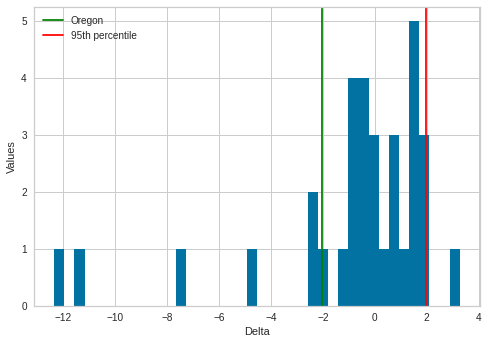

In [ ]:
# Visualisation histogramme placebo 

X = list(df_delta30_placebo[30])

Z = X + [df_delta30.loc['OR'][30]]

plt.axvline(x = df_delta30.loc['OR'][30], color = "green", label = "Oregon")

plt.axvline(x = p, color = "red", label = "95th percentile")

plt.hist(Z, bins = 40)
plt.xlabel("Delta")
plt.ylabel("Values")
plt.legend()
plt.show()



1.9619999999999997


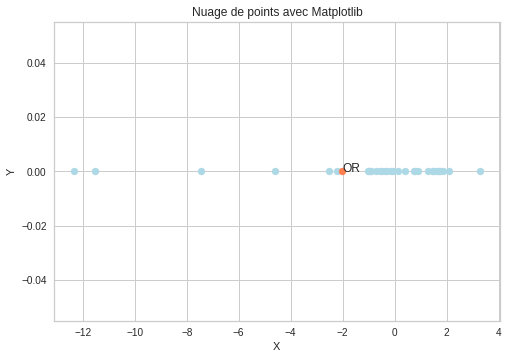

In [ ]:
# Visualisation 1D placebo 30 jours de fit

X = list(df_delta30_placebo[30])

Z = X + [df_delta30.loc['OR'][30]]
Z = np.array(Z)

alpha=max(X)
beta = min(X)
Y = [0 for k in range(len(X))]
titles = list(df_delta30_placebo.index)


plt.scatter(X, Y, c='lightblue')

plt.xlabel("X")
plt.ylabel("Y")

X = [df_delta30.loc['OR'][30]]
Y = [0]

plt.scatter(X, Y, c='coral')

plt.title('Nuage de points avec Matplotlib')
plt.xlabel('X')
plt.ylabel('Y')
plt.annotate('OR', (X[0], Y[0]))
alpha = max([alpha,X[0]])
beta = min([beta,X[0]])

p = np.percentile(Z,95)
print(p)
plt.show()


In [ ]:
df_delta_f = pd.concat([df_delta30, df_delta40,df_delta50,df_delta60], axis=1)
df_fit_f = pd.concat([df_fit30, df_fit40,df_fit50,df_fit60], axis=1)

df_delta_f

,0,30,60,90,0,30,60,90,0,30,60,90,0,30,60,90
AL,-0.77,-0.50,-0.51,-0.17,-0.96,-0.67,-0.65,-0.31,-0.58,-0.10,0.02,-0.25,-0.25,0.18,0.29,0.58
AR,0.09,0.54,1.21,-1.41,0.15,0.88,1.63,-1.18,0.17,1.02,1.78,-0.99,0.16,0.99,1.76,-1.04
CA,0.23,0.99,0.42,-0.29,0.51,1.85,1.45,0.60,0.39,1.49,1.19,0.36,0.22,0.48,-0.07,-0.87
CO,0.65,1.58,2.30,2.55,1.02,2.46,3.26,3.39,0.58,1.68,2.47,2.71,0.59,1.73,2.53,2.78
CT,2.80,3.50,3.40,2.60,2.80,3.50,3.40,2.60,2.80,3.50,3.40,2.60,2.80,3.50,3.40,2.60
DE,0.50,0.50,0.90,1.00,0.50,0.50,0.90,1.00,0.50,0.50,0.90,1.00,0.50,0.50,0.90,1.00
IL,0.20,-0.40,-0.70,-0.60,0.20,-0.40,-0.70,-0.60,0.20,-0.40,-0.70,-0.60,0.20,-0.40,-0.70,-0.60
ID,0.49,1.07,1.99,2.31,-0.70,-0.30,0.50,0.70,-0.34,0.12,0.96,1.20,-0.70,-0.30,0.50,0.70
KY,-0.08,0.79,0.57,-0.42,-0.19,0.66,0.67,0.11,-0.28,0.54,0.73,0.46,-0.22,0.62,0.71,0.65
ME,-0.02,1.07,0.69,0.21,1.28,6.47,6.29,5.66,1.38,6.34,6.09,5.43,1.28,6.46,6.28,5.65


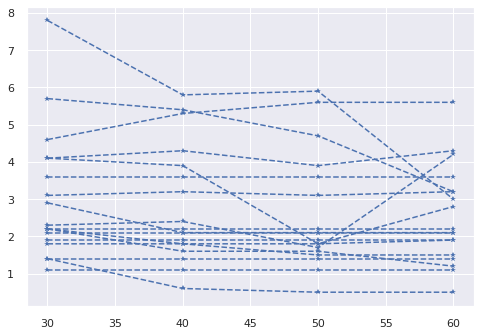

,%,%,%,%
AL,5.7,5.4,4.7,3.2
AR,1.4,0.6,0.5,0.5
CA,2.2,1.8,1.5,1.5
CO,1.8,1.8,1.8,1.9
CT,3.6,3.6,3.6,3.6
DE,1.9,1.9,1.9,1.9
IL,1.1,1.1,1.1,1.1
ID,4.1,4.3,3.9,4.3
KY,2.2,1.6,1.6,1.2
ME,2.9,2.1,2.1,2.1


In [ ]:
df_fit_f

ls_fit = df_fit_f.to_numpy()

t = [30,40,50,60]
for i in range(len(df_fit_f)):
  plt.plot(t, ls_fit[i], 'b*--')
plt.show()
df_fit_f

Alabama


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning:

overflow encountered in exp

/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning:

Covariance of the parameters could not be estimated



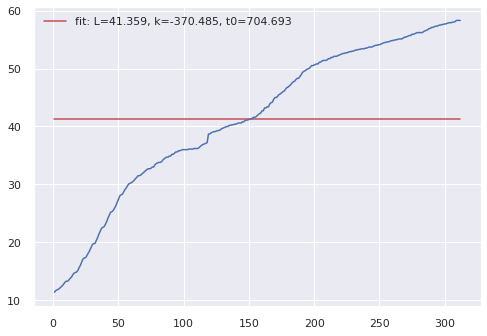

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning:

overflow encountered in exp

/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning:

Covariance of the parameters could not be estimated



Arkansas


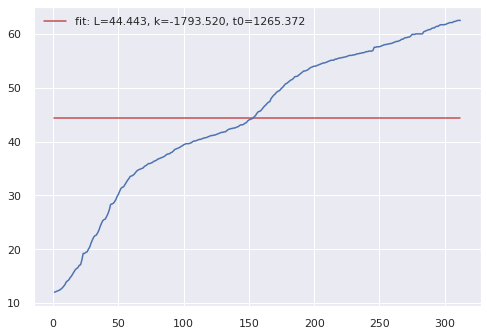

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning:

overflow encountered in exp



California


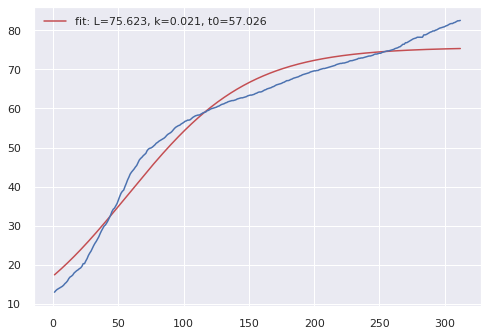

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning:

overflow encountered in exp

/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning:

Covariance of the parameters could not be estimated



Colorado


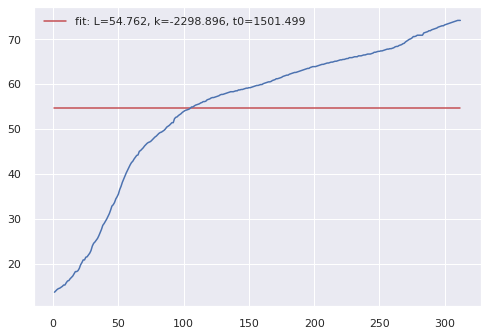

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning:

overflow encountered in exp

/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning:

Covariance of the parameters could not be estimated



Connecticut


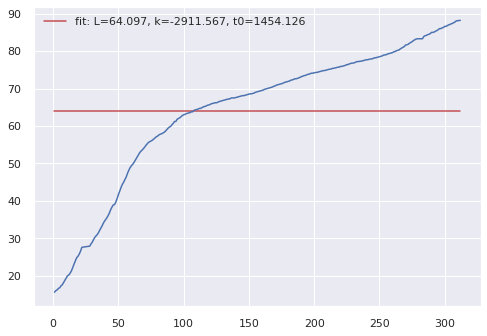

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning:

overflow encountered in exp



Delaware


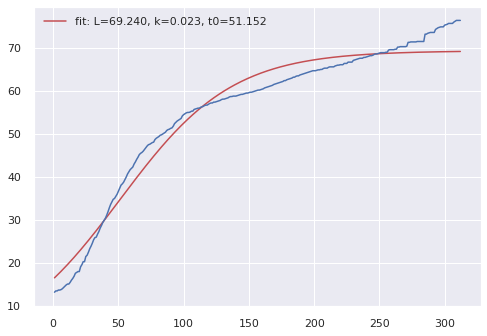

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning:

overflow encountered in exp

/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning:

Covariance of the parameters could not be estimated



Illinois


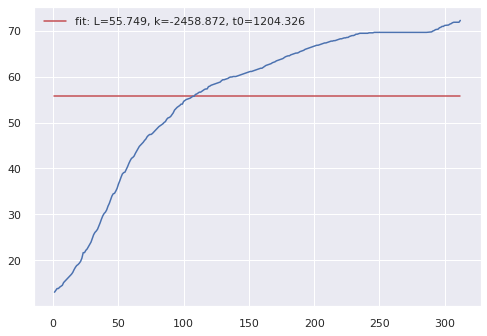

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning:

overflow encountered in exp

/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning:

Covariance of the parameters could not be estimated



Idaho


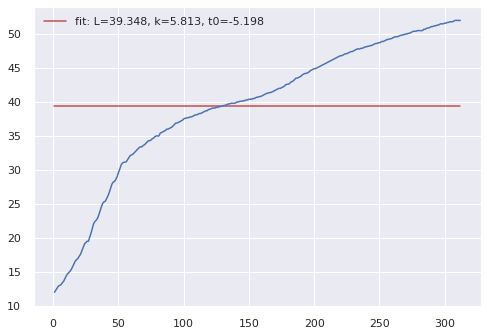

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning:

overflow encountered in exp

/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning:

Covariance of the parameters could not be estimated



Kentucky


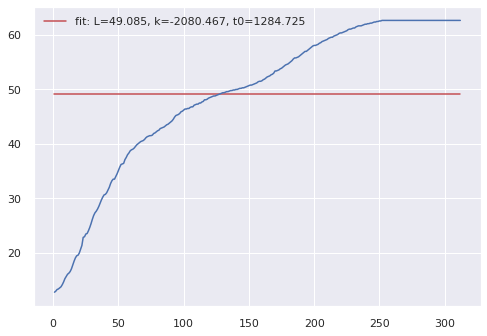

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning:

overflow encountered in exp



Maine


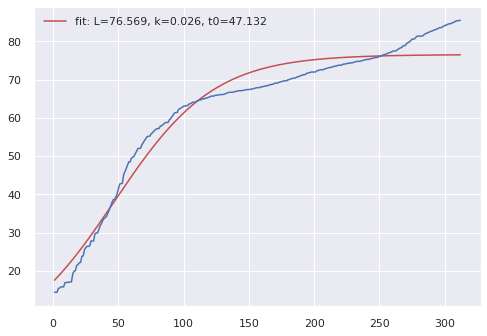

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning:

overflow encountered in exp



Maryland


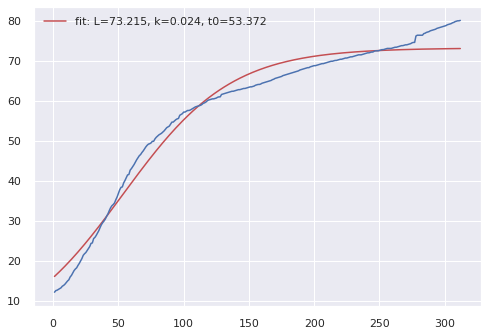

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning:

overflow encountered in exp

/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning:

Covariance of the parameters could not be estimated



Michigan


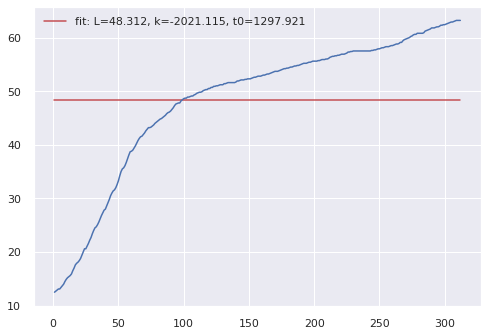

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning:

overflow encountered in exp

/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning:

Covariance of the parameters could not be estimated



Minnesota


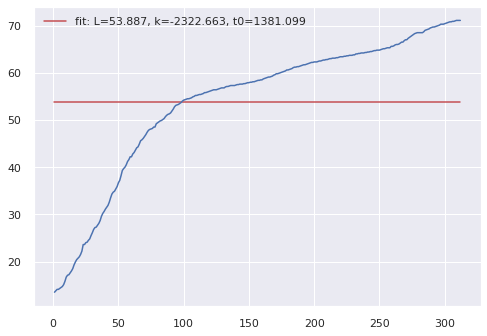

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning:

overflow encountered in exp



New Jersey


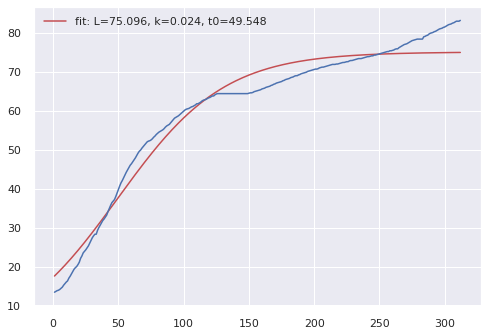

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning:

overflow encountered in exp

/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning:

Covariance of the parameters could not be estimated



New York


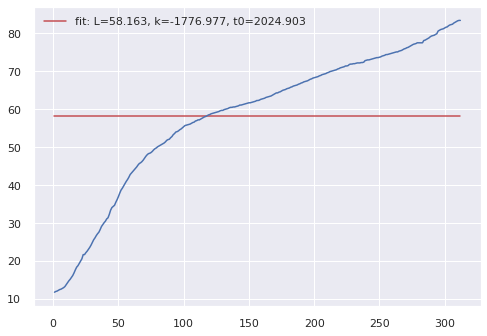

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning:

overflow encountered in exp

/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning:

Covariance of the parameters could not be estimated



Ohio


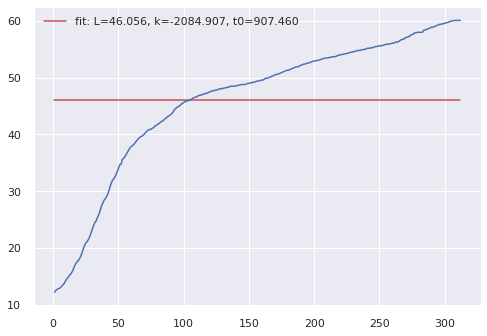

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning:

overflow encountered in exp



Oregon


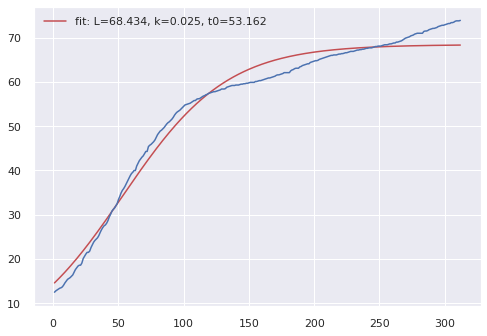

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning:

overflow encountered in exp

/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning:

Covariance of the parameters could not be estimated



West Virginia


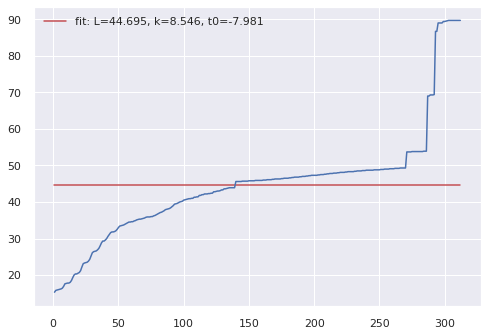

In [ ]:
# Logistic regression

from scipy.optimize import curve_fit

for X in target_states_all:
  tspan = np.linspace(1,len(ls_dose1[X]), len(ls_dose1[X]))
  def func(t, L, k, tc):
    return L/(1+np.exp(-k*(t-tc)))

  popt, pcov = curve_fit(func, tspan, ls_dose1[X])
  print(states_names[X])
  plt.plot(tspan, func(tspan, *popt), 'r-', label='fit: L=%5.3f, k=%5.3f, t0=%5.3f' % tuple(popt))
  plt.plot(tspan, ls_dose1[X], 'b-')
  plt.legend()
  plt.show()
